# Modeling the growth of COVID-19

In [176]:
import matplotlib.pyplot as plt
import numpy
import pandas
import pymc3

Read the time series as a CSV from ESRI AGOL:

In [280]:
TIME_SERIES_URL = (
    "http://lahub.maps.arcgis.com/sharing/rest/content/items/"
    "f912069273894509b7fcb5c71fae2366/data?token=UgSf2FNvvZyPOS"
    "oB8dDlMy8g1fZ3XBFE2AmQuc8z5XD3b93M4_wEYkpJ8zdO5tVOq5ZW3HtZT"
    "qXxOpgkKRpr4mxweN2XcIsqdr4055FRfC1D-QZOwn9V8SU3rtJPaol--b7rL"
    "hKUyrmmAlpR_LA9bmbgY3Md1WvQUZ61JKcaeGmrj3dn-CSGA1okD8dtadZUsIZU"
    "-vXHCyGFFy8mrfMnhw.."
)

df = pandas.read_csv(
    TIME_SERIES_URL,
    parse_dates=["date"],
).sort_values("date")

Subset to LA County and drop the last date which might not have been
updated yet.

In [281]:
la = (
    df[df.county == "Los Angeles"]
    .reset_index(drop=True)
    .iloc[:-1]
)

Compute the number of days since the number of cases reached a threshold,
here we choose 10.

In [282]:
# Start modeling once the cases reach a certain threshhold.
# In this case, arbitrarily choose 10 cases
START_CASES = 10

# Number of days to model when extrapolating
N_MODEL_DAYS = 30

idx = (la.cases - START_CASES).abs().idxmin()
start_date = la.date.iloc[idx]
la = (
    la[la.date >=start_date]
    .assign(days_since_start=(la.date-start_date).dt.days)
    .reset_index(drop=True)
)

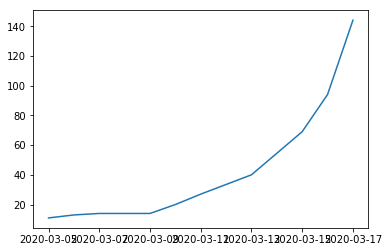

In [283]:
plt.plot(la.date, la.cases)

Create the Bayesian model.

In [287]:
with pymc3.Model() as model:
    # Model the initial value as a random variable
    # with an exponential prior. This distribution
    # has a mean of START_CASES, but we allow it to
    # be different to account for measurement error.
    a = pymc3.Exponential(
        'a',
        lam=1./START_CASES,
    )
    # Model the doubling timescale as another random variable
    # with exponential prior. The mean of the distribution
    # is chosen to be a 5 day doubling time.
    tau = pymc3.Exponential(
        'tau', 
        lam=1./5.,
    )
    
    # An error term to associate with the observations
    sigma = pymc3.HalfNormal('sigma', sigma=50.)
            
    # By using pm.Data we can change these values after sampling.
    # This allows us to extend x into the future so we can get
    # forecasts by sampling from the posterior predictive
    x = pymc3.Data("x_data", la.days_since_start.values)
    cases = pymc3.Data("y_data", la.cases.values)

    # Likelihood
    pymc3.NegativeBinomial(
        'counts', 
        (a * 2. ** (x/tau)), # Exponential regression
        sigma, 
        observed=cases
    )

In [288]:
with model:
    # Sample posterior
    trace = pymc3.sample(tune=1500, chains=1, cores=1, target_accept=.9)
    
    # Update data so that we get predictions into the future
    x_data = numpy.arange(0, N_MODEL_DAYS)
    y_data = numpy.array([numpy.nan] * len(x_data))
    pymc3.set_data({"x_data": x_data})
    pymc3.set_data({"y_data": y_data})
    
    # Sample posterior predictive
    post_pred = pymc3.sample_posterior_predictive(trace, samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, tau, a]
Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 617.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
100%|██████████| 100/100 [00:00<00:00, 136.87it/s]


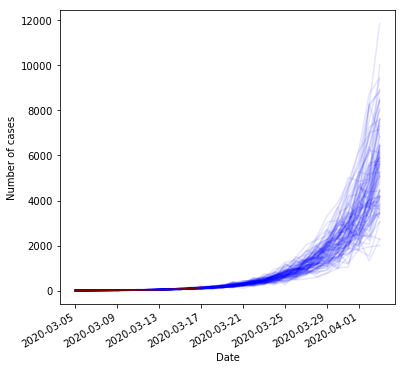

In [289]:
fig, ax = plt.subplots(figsize=(6,6))
daterange = pandas.date_range(
    start=date,
    end=(date+pandas.Timedelta(days=N_MODEL_DAYS-1))
)
for i in post_pred['counts']:
    ax.plot(daterange.values, i, color='blue', alpha=0.1)
ax.plot(la.date, la.cases, color='maroon')
#ax.set_xlim(0, 20)
#ax.set_ylim(0, 1000)
ax.set_xlabel("Date")
ax.set_ylabel("Number of cases")
fig.autofmt_xdate()
fig.show()

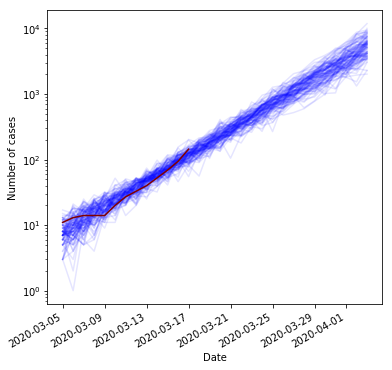

In [290]:
fig, ax = plt.subplots(figsize=(6,6))
daterange = pandas.date_range(
    start=date,
    end=(date+pandas.Timedelta(days=N_MODEL_DAYS-1))
)
for i in post_pred['counts']:
    ax.semilogy(daterange.values, i, color='blue', alpha=0.1)
ax.semilogy(la.date, la.cases, color='maroon')
ax.set_xlabel("Date")
ax.set_ylabel("Number of cases")
fig.autofmt_xdate()
fig.show()

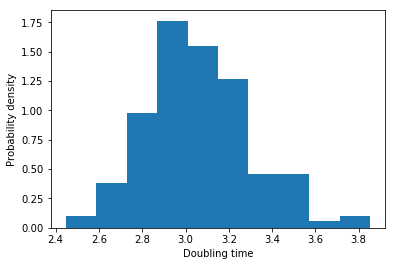

In [295]:
fig, ax = plt.subplots()
ax.hist(trace.tau, density=True)
ax.set_xlabel("Doubling time")
ax.set_ylabel("Probability density")
fig.show()